## 1. Data Pre-processing

### 1.1 Load Data

In [1]:
pip install fredapi

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install rich

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np

API_KEY = '1vGb0FOsg2hEIGrEhpueLCcWd1Y'
FRED_API_KEY = 'b13a905b98b5dfc1f3910d6a0d875ae3'

rootUrl = 'https://api.glassnode.com'

symbolList = ['BTC', 'ETH', 'LTC', 'AAVE', 'ABT', 'AMPL', 'ANT', 'ARMOR', 'BADGER', 'BAL', 'BAND', 'BAT', 'BIX', 'BNT', 'BOND', 'BRD', 'BUSD', 'BZRX', 'CELR', 'CHSB', 'CND', 'COMP', 'CREAM', 'CRO', 'CRV', 'CVC', 'CVP', 'DAI', 'DDX', 'DENT', 'DGX', 'DHT', 'DMG', 'DODO', 'DOUGH', 'DRGN', 'ELF', 'ENG', 'ENJ', 'EURS', 'FET', 'FTT', 'FUN', 'GNO', 'GUSD', 'HEGIC', 'HOT', 'HPT', 'HT', 'HUSD', 'INDEX', 'KCS', 'LAMB', 'LBA', 'LDO', 'LEO', 'LINK', 'LOOM', 'LRC', 'MANA', 'MATIC',
              'MCB', 'MCO', 'MFT', 'MIR', 'MKR', 'MLN', 'MTA', 'MTL', 'MX', 'NDX', 'NEXO', 'NFTX', 'NMR', 'Nsure', 'OCEAN', 'OKB', 'OMG', 'PAY', 'PERP', 'PICKLE', 'PNK', 'PNT', 'POLY', 'POWR', 'PPT', 'QASH', 'QKC', 'QNT', 'RDN', 'REN', 'REP', 'RLC', 'ROOK', 'RPL', 'RSR', 'SAI', 'SAN', 'SNT', 'SNX', 'STAKE', 'STORJ', 'sUSD', 'SUSHI', 'TEL', 'TOP', 'UBT', 'UMA', 'UNI', 'USDC', 'USDK', 'USDP', 'USDT', 'UTK', 'VERI', 'WaBi', 'WAX', 'WBTC', 'WETH', 'wNXM', 'WTC', 'YAM', 'YFI', 'ZRX']

symbolListShort = ['BTC', 'ETH', 'LTC', 'AAVE', 'MLN', 'YAM']

endPoints = {
    'Price': '/v1/metrics/market/price_usd_close',
    'MarketCap': '/v1/metrics/market/marketcap_usd',
    'ActiveAddress': '/v1/metrics/addresses/active_count',
}

### 1.2 Get Multiple Attributes for Multiple Coins:

In [4]:
def PullData(coin: str,
             feature: str):
    """This Method Pull Data According to Input Parameters(coin, feature)

    Args:
        coin (str): Name of a Coin. Like: "BTC"
        feature (str): Feature of a Coin. Like: "Price"

    Returns:
        data (pd.DataFrame): A DataFrame Contains Date and Feature of One Coin
    """
    import requests

    # Assemble full request url and get responses:
    reqUrl = rootUrl + endPoints[feature]
    res = requests.get(reqUrl,
                       params={'a': coin,
                               'api_key': API_KEY,
                               'i': '1w'})
    data_raw = pd.read_json(res.text,
                            convert_dates=['t'])

    # Rename column "v" according to features
    data = data_raw.rename(columns={"v": f"{feature}",
                                    't': 'Date'})

    # Return a dataframe
    return data

In [5]:
def PullStart(coinList: list):
    """This Method Gets Features(Listed in "endPoints"(Constant)) of Coins(Listed in "coinList"(Method Parameter))

    Args:
        coinList (list): The List of Coins' Name

    Returns:
        fullFrame (pd.DataFrame): A DataFrame Contains All Features of Listed Coin's
    """
    # Initialization
    from functools import reduce
    from fredapi import Fred
    from rich.console import Console
    console = Console()

    colName = ["Date"]
    for key in endPoints.items():
        colName.append(key)
    fullFrame = pd.DataFrame(columns=colName.append("Asset"))

    # Show Welcome
    console.print(
        "Loading [bold magenta]All Coins[/bold magenta] Data. This Might Take A While")

    # Pull Fred RiskFree
    fred = Fred(api_key=FRED_API_KEY)
    Risk_free_rate = fred.get_series('DGS1MO').to_frame().reset_index().rename(columns={'index': 'Date',
                                                                                        0: 'RiskFree'})
    Risk_free_rate['RiskFree'] = Risk_free_rate['RiskFree'] / 100

    # Init Loop Count
    count = 1

    # Data Pull
    for i in coinList:
        # Preparation for merging
        frameName = f"{i}_Frames"
        locals()[frameName] = []

        # Progress Bar Init
        from rich.progress import (Progress,
                                   TextColumn,
                                   BarColumn,
                                   TaskProgressColumn,
                                   TimeRemainingColumn)

        progress = Progress(TextColumn("[progress.description]{task.description}"),
                            BarColumn(),
                            TaskProgressColumn(),
                            TimeRemainingColumn(compact=True,
                                                elapsed_when_finished=True,),
                            expand=True,
                            transient=True)

        with progress:
            # Get data
            for j in progress.track(endPoints.keys(),
                                    description=f"Pulling {i}'s Data, Coins Ramaining: {len(coinList) - count}"):
                locals()[frameName].append(PullData(i,
                                                    j))

        # Loop Count + 1
        count += 1

        # Merge 2-column dataframes to a single dataframe
        dfName = f"{i}_All"
        # Outer Merge Glassnode to Ensure Not Missing Any Values.
        # Left Merge Fred to ensure all the records in api stored.
        locals()[dfName] = reduce(lambda left, right:
                                  pd.merge(left, right,
                                           on='Date',
                                           how='outer'),
                                  locals()[frameName]).merge(Risk_free_rate,
                                                             on='Date',
                                                             how='left').sort_values(by=['Date'])
        locals()[dfName]['Asset'] = i

        # Merge All Coins into a single Dataframe
        fullFrame = pd.concat([fullFrame, locals()[dfName]],
                              ignore_index=True)

    console.print('All Frames Merged')
    console.print('\nALL DATA [bold green]SUCCESSFULLY[/bold green] PULLED!')

    return fullFrame

### 1.3 Imputation for NA values using linear interpolation method

If the price for the asset is missing for the latest 4 weeks , then we consider it as a cryto currency that stopped trading, we won't include it in our sample. (this should be done before return calculation)

In [6]:
def InterpolationImpute(sample: pd.DataFrame):
    """This Method will impute NA values using linear interpolation method

    Args:
        sample (pd.DataFrame): The Pulled Data 

    Returns:
        fullFrame (pd.DataFrame): A DataFrame Imputed all NA using linear interpolation
    """
    # Initialization
    imputedFrame = pd.DataFrame(columns=list(sample.columns))

    orgcols = list(sample.columns)
    cols = orgcols.copy()
    cols.remove('Date')
    cols.remove('Asset')
    for index in sample['Asset'].unique().tolist():
        syntax = f"Asset == '{index}'"
        segment = sample.query(syntax)

#if the price for the asset is missing for the latest **4 weeks** ,
#then we consider it as a cryto currency that stopped trading, we won't include it in our sample

        if (segment['Price'][-4:].isnull().sum() < 4):
            temp = segment[cols].interpolate(
                method='linear', limit_direction='forward', axis=0)
            temp['Asset'] = segment['Asset']
            temp['Date'] = segment['Date']
            imputedFrame = pd.concat([imputedFrame, temp[orgcols]],
                                     ignore_index=True)

    return imputedFrame

### 1.4 Calculate Returns

In [7]:
def AddReturn(sample: pd.DataFrame):
    """This Method Add Return Column to Pulled Raw Data

    Args:
        sample (pd.DataFrame): The Raw Pulled Data without a Return Column

    Returns:
        fullFrame (pd.DataFrame): DataFrame with a Return Column
    """
    fullFrame = pd.DataFrame(columns=list(sample.columns).append(['Return','week2_return','Npast52','GrowthRate']))
    for index in sample['Asset'].unique().tolist():
        syntax = f"Asset == '{index}'"
        segment = sample.query(syntax)
        # Only Select 53 Weeks for Test
#         temp = segment[-53:-1].reset_index().drop('index', axis=1)
#         segment = segment[-52:].reset_index().drop('index', axis=1)
        segment = segment.assign(Return = segment.Price.rolling(2).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0]).copy())
        segment = segment.assign(week2_return = segment.Price.rolling(4).apply(lambda x: (x.iloc[-2]-x.iloc[0])/x.iloc[0]))
        segment = segment.assign(Npast52_return = segment.Price.rolling(53).apply(lambda x: (x.iloc[-2]-x.iloc[0])/x.iloc[0]))
        
        ####add growth rate
        segment = segment.assign(GrowthRate = segment.ActiveAddress.rolling(2).apply(lambda x: np.log(x.iloc[-1])-np.log(x.iloc[0])
                                                                                     if ((x.iloc[0]>0 and x.iloc[-1]>0)) else np.nan ))
                                                                                                                                                                                                                                                                                                       
                                                                                                                
        segment = segment[-52:].reset_index(drop=True)
        fullFrame = pd.concat([fullFrame, segment],
                                     ignore_index=True)
        fullFrame["ExcessReturn"] = fullFrame["Return"] - fullFrame["RiskFree"]

    return fullFrame

### 1.5 Initialize 

In [8]:
# Get fullSample Raw Data(Without Return)
fullSample_raw = PullStart(symbolList)

Loading All Coins Data. This Might Take A While

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

All Frames Merged

ALL DATA SUCCESSFULLY PULLED!

In [16]:
# Impute missing value using interploration method
imputedfullSample = InterpolationImpute(fullSample_raw)
imputedfullSample

,Date,Price,MarketCap,ActiveAddress,RiskFree,Asset
0,2008-12-29,NaN,NaN,0.0,0.0004,BTC
1,2009-01-05,NaN,NaN,0.0,0.0005,BTC
2,2009-01-12,NaN,NaN,34.0,0.0004,BTC
3,2009-01-19,NaN,NaN,63.0,0.0003,BTC
4,2009-01-26,NaN,NaN,61.0,0.0002,BTC
...,...,...,...,...,...,...
22863,2022-04-04,0.754619,6.395366e+08,1284.0,0.0018,ZRX
22864,2022-04-11,0.686854,5.821057e+08,1266.0,0.0022,ZRX
22865,2022-04-18,0.808817,6.854696e+08,2274.0,0.0038,ZRX
22866,2022-04-25,0.717148,6.077804e+08,1699.0,0.0040,ZRX


In [18]:
# Add Return to fullSample
fullSample = AddReturn(imputedfullSample)

### 1.6 Get the large capitalization portfolio - largeCapSample 
Use (maket cap > 1m and top 100) to set up the dynamic porfolio for each week, we would use this dynamic portfolio for our factors calculation.

In [19]:
largeCapport = fullSample.query("MarketCap > 1000000")
largeCapSample = largeCapport.groupby(['Date']).apply(lambda x: x.nlargest(100,['MarketCap'])).reset_index(drop=True)

### 1.7 Generate csv file for the loaded raw data

In [71]:
latestdate = fullSample_raw.Date.max()
filename1 = "fullSample_rawdata"+latestdate.strftime("%Y%m%d")+".csv"

fullSample_raw.to_csv(filename1)

In [72]:
fullSample_raw.tail()

,Date,Price,MarketCap,ActiveAddress,RiskFree,Asset
23575,2022-04-04,0.754619,6.395366e+08,1284.0,0.0018,ZRX
23576,2022-04-11,0.686854,5.821057e+08,1266.0,0.0022,ZRX
23577,2022-04-18,0.808817,6.854696e+08,2274.0,0.0038,ZRX
23578,2022-04-25,0.717148,6.077804e+08,1699.0,0.0040,ZRX
23579,2022-05-02,0.622694,5.277308e+08,1298.0,0.0041,ZRX


## 2. MKT Factor (Fiona)

### 2.1 Calculate MKT for each week

We chose the crypto currencies which have market cap greatter than 1m and ranked in the top 100 as our market portfolio and using value weighted method to calcuate the market index return.

In [27]:
## largeCapSample is a big dataframe include all crypto currencies makcap greater than 1000000
marketport = largeCapSample.groupby('Date')['MarketCap'].sum().reset_index(name='TotalMarketCap')
marketInd = largeCapSample.copy()
marketInd['weights'] = marketInd['Return'] * marketInd['MarketCap']
recomp = marketInd.groupby('Date')['weights'].sum().reset_index(name='TotalMarketReturn')
marketport['MarketIndexReturn'] = recomp['TotalMarketReturn']/ marketport['TotalMarketCap']

In [28]:
riskfree = largeCapSample.groupby('Date')['RiskFree'].mean().reset_index()
marketport = marketport.merge(riskfree, on='Date')
marketport['MKT'] = marketport['MarketIndexReturn'] - marketport['RiskFree']
MKT_f = marketport[['Date','MKT']]

### 2.2 MKT_f - market factor

In [16]:
MKT_f.head()

,Date,MKT
0,2021-05-10,-0.145881
1,2021-05-17,-0.280399
2,2021-05-24,0.069425
3,2021-05-31,0.042021
4,2021-06-07,0.029528


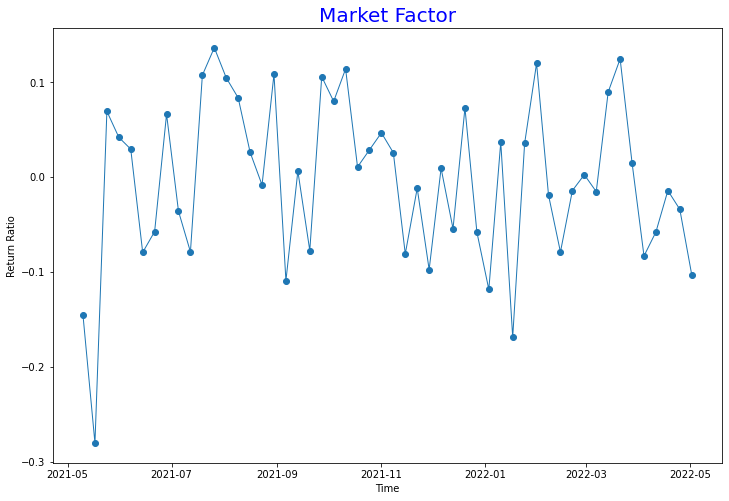

In [17]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
 
plt.plot(MKT_f.Date, MKT_f.MKT, marker='o', linewidth=1)

plt.title("Market Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Return Ratio")
plt.show()

### <font color='green'> Test for mkt factor
    value weighted return= weight1 * return1 + weight2 * return 2 + ...
    weight1 = cap1/cap_sum,  weight2 = cap2/cap_sum ...
    value weighted return = cap1  * return1/cap_sum  + cap2 * return2/cap_sum + ..
                          = (cap1 * return1 + cap2 * return2 + ...)/cap_sum

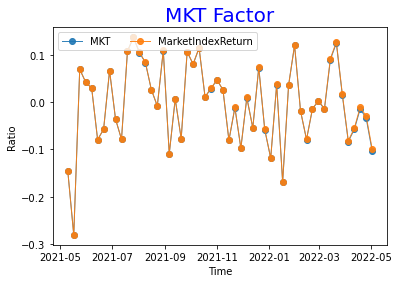

In [18]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

factors = marketport[["Date", "MKT","MarketIndexReturn"]]

palette = plt.get_cmap('Set1')
 
num=0
for column in factors.drop('Date', axis=1):
    num+=1
    plt.plot(factors['Date'], factors[column], marker='o', linewidth=1, alpha=0.9, label=column)


plt.legend(loc=2, ncol=2)
plt.title("MKT Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Ratio")
plt.show()

### Test

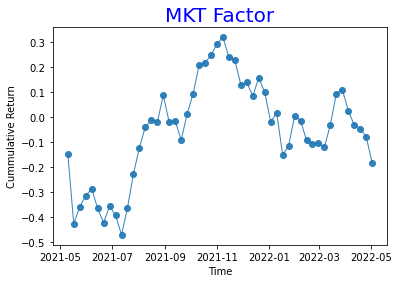

In [19]:
plt.plot(MKT_f.Date, np.cumsum(MKT_f.MKT), marker='o', linewidth=1, alpha=0.9, label=column)
plt.title("MKT Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Cummulative Return")
plt.show()

## 3. SMB Factor (Fiona)

### 3.1 Using quintile method to get the portfolios for top 20%, and bottom 20% based on the cap for each week

Using equal weighted method to calucated the returns for the small protfolios and large portfolios. The difference is the SMB factor.

In [47]:
largeCap = largeCapSample.groupby(['Date']).apply(lambda 
                                                x: x.nlargest(round(0.2*len(x)),
                                                              ['MarketCap'])).reset_index(drop=True)

smallCap = largeCapSample.groupby(['Date']).apply(lambda 
                                                x: x.nsmallest(round(0.2*len(x)),
                                                              ['MarketCap'])).reset_index(drop=True)
largeCap.head()

,Date,Price,MarketCap,ActiveAddress,RiskFree,Asset,Return,week2_return,Npast52_return,GrowthRate,ExcessReturn
0,2021-05-10,46406.331544,8.683518e+11,6062366.0,0.0002,BTC,-0.202895,0.187168,5.020518,-0.088389,-0.203095
1,2021-05-10,3582.328055,4.152052e+11,3482956.0,0.0002,ETH,-0.089013,0.699593,17.982967,-0.018539,-0.089213
2,2021-05-10,1.000012,5.737547e+10,564831.0,0.0002,USDT,-0.000014,0.000057,-0.002087,-0.020966,-0.000214
3,2021-05-10,296.493781,2.006374e+10,1530001.0,0.0002,LTC,-0.231293,0.722933,7.838155,0.061791,-0.231493
4,2021-05-10,36.470417,1.987142e+10,24522.0,0.0002,UNI,-0.075351,0.156817,NaN,-0.408560,-0.075551


### 3.2 Using equal-weighted average method to get the SMB
SMB = equal-weighted average of returns on small portfolis - equal-weighted average of returns on large portfolis

In [48]:
largeport = largeCap.groupby('Date')['Return'].mean().reset_index(name='LargePortReturn')
smallport = smallCap.groupby('Date')['Return'].mean().reset_index(name='SmallPortReturn')
smallport['SMB'] = smallport['SmallPortReturn'] - largeport['LargePortReturn']
SMB_f = smallport[['Date','SMB']]

In [49]:
SMB_f.head()

,Date,SMB
0,2021-05-10,-0.189053
1,2021-05-17,-0.148497
2,2021-05-24,0.004411
3,2021-05-31,0.029201
4,2021-06-07,-0.033515


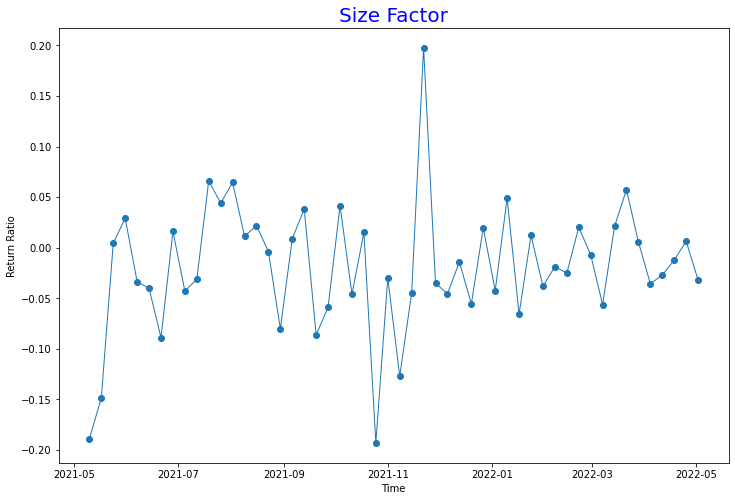

In [50]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
 
plt.plot(SMB_f.Date, SMB_f.SMB, marker='o', linewidth=1)

plt.title("Size Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Return Ratio")
plt.show()

### <font color = 'green'> Test SMB

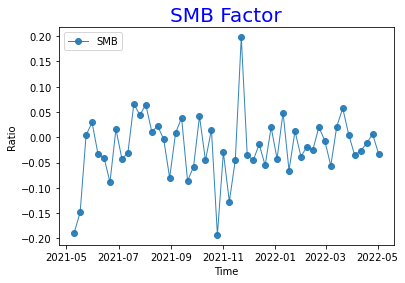

In [40]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

factors = SMB_f

palette = plt.get_cmap('Set1')
 
num=0
for column in factors.drop('Date', axis=1):
    num+=1
    plt.plot(factors['Date'], factors[column], marker='o', linewidth=1, alpha=0.9, label=column)


plt.legend(loc=2, ncol=2)
plt.title("SMB Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Ratio")
plt.show()

### Test

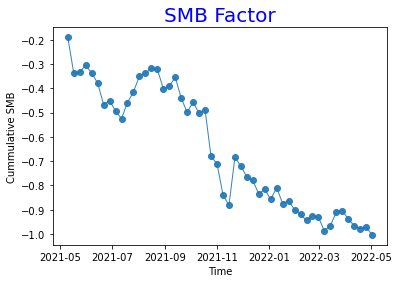

In [41]:
plt.plot(SMB_f.Date, np.cumsum(SMB_f.SMB), marker='o', linewidth=1, alpha=0.9, label=column)
plt.title("SMB Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Cummulative SMB")
plt.show()

## 4. VAL Factor (Lydia)

**Reshape to get two tables with: Npast52_return, Return(weekly)**

In [42]:
npast52 = largeCapSample.loc[:,['Date', 
                                  'Npast52_return', 
                                  'Asset']].pivot(index="Date", 
                                                  columns=["Asset"], 

                                                  values='Npast52_return').reset_index().rename_axis(None, 
                                                                                                     axis=1).sort_values('Date')


value_return = largeCapSample.loc[:,['Date','Asset','Return']].pivot(index='Date',
                                                              columns = ['Asset'],
                                                              values = 'Return').reset_index().rename_axis(None,
                                                                                                          axis=1).sort_values('Date')



In [43]:
cols=list(largeCapSample.Asset.unique())

npast52['top20'] = npast52[cols].quantile(q=0.8,axis=1, numeric_only=True, interpolation='linear') 
npast52['low20'] = npast52[cols].quantile(q=0.2,axis=1, numeric_only=True, interpolation='linear') 

**check whether Npast52 of a coin in a day is in low20 or top20, then calculate the weekly return mean of low20 and top20 , respectively**

In [44]:
VAL_low = value_return[npast52[cols].apply(lambda x: x <= npast52['low20'])].mean(axis=1, numeric_only=True)
VAL_top = value_return[npast52[cols].apply(lambda x: x >= npast52['top20'])].mean(axis=1, numeric_only=True)

**calculate Value factor using long-short method**

In [45]:
valueFactor = pd.DataFrame(columns = ['Date','VAL'])
valueFactor['Date'] = value_return['Date']
valueFactor['VAL'] = VAL_top - VAL_low

In [46]:
valueFactor.head()

,Date,VAL
0,2021-05-10,-0.084175
1,2021-05-17,-0.289402
2,2021-05-24,0.141890
3,2021-05-31,0.103929
4,2021-06-07,-0.117408


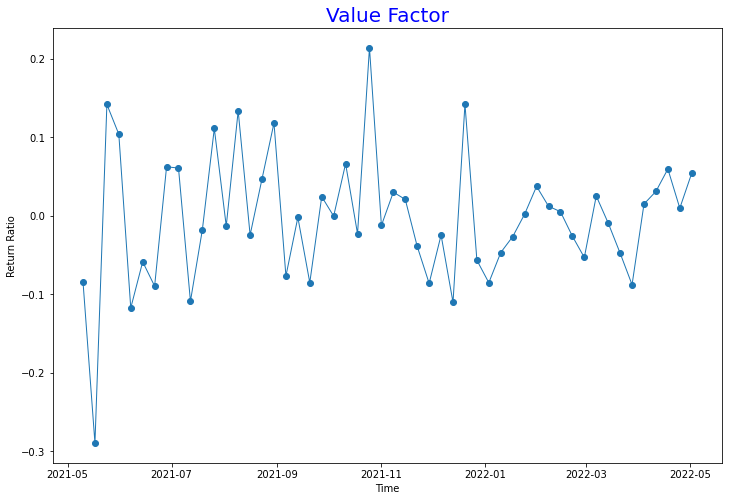

In [38]:
from matplotlib.pyplot import figure

plt.figure(figsize=(12,8))
 
plt.plot(valueFactor.Date, valueFactor.VAL, marker='o', linewidth=1)

plt.title("Value Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Return Ratio")
plt.show()

### Test

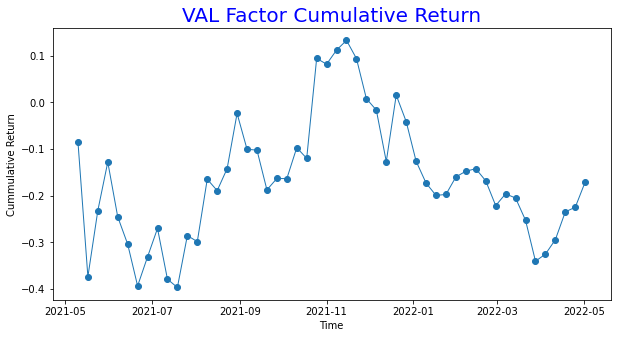

In [47]:
from matplotlib.pyplot import figure

figure(figsize=(10,5))
plt.plot(valueFactor.Date, np.cumsum(valueFactor.VAL), marker='o', linewidth=1)
plt.title("VAL Factor Cumulative Return", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Cummulative Return")
plt.show()

## 5. MOM Factor (Sean)

In [51]:
def getMomFactor(largeCapSample: pd.DataFrame):
    """This Method Returns Momentum Factor

    Args:
        largeCapSample (pd.DataFrame): Large Cap Sample

    Returns:
        momFactor (pd.DataFrame): Contains Momentum Factor
    """
    # Pivot largeCapSample to Get Return Matrix
    returnAll = largeCapSample.loc[:, ['Date',
                                   'Return',
                                       'Asset']].pivot(index="Date",
                                                       columns=["Asset"],
                                                       values='Return').reset_index().rename_axis(None,
                                                                                                  axis=1).sort_values('Date')
    
    # Pivot largeCapSample to Get Momentum Matrix(Past 2-Week Returns)
    momMatrix = largeCapSample.loc[:, ['Date',
                                       'week2_return',
                                       'Asset']].pivot(index="Date",
                                                       columns=["Asset"],
                                                       values='week2_return').reset_index().rename_axis(None,
                                                                                                        axis=1).sort_values('Date')

    # Calculate the Momentum Percentile
    col = []
    for colName in momMatrix.columns:
        if colName not in ['Date']:
            col.append(colName)
    momMatrix[col].head()

    momPt = pd.DataFrame(columns=['MOM20p',
                                  'MOM80p'])

    momPt['MOM20p'] = momMatrix[col].quantile(.2, axis=1)
    momPt['MOM80p'] = momMatrix[col].quantile(.8, axis=1)

    # Calculate MOM Factor
    MOM = pd.DataFrame({'Date': []})
    MOM['Date'] = returnAll.Date
    MOM['HighMomentum'] = returnAll[momMatrix[largeCapSample.Asset.unique()].apply(
        lambda x: x >= momPt['MOM80p'])].mean(axis=1, numeric_only=True)
    MOM['LowMomentum'] = returnAll[momMatrix[largeCapSample.Asset.unique()].apply(
        lambda x: x <= momPt['MOM20p'])].mean(axis=1, numeric_only=True)
    MOM['MOM'] = MOM.HighMomentum - MOM.LowMomentum
    momFactor = MOM.drop(columns=['HighMomentum', 'LowMomentum'])
    return momFactor


In [52]:
momFactor = getMomFactor(largeCapSample)

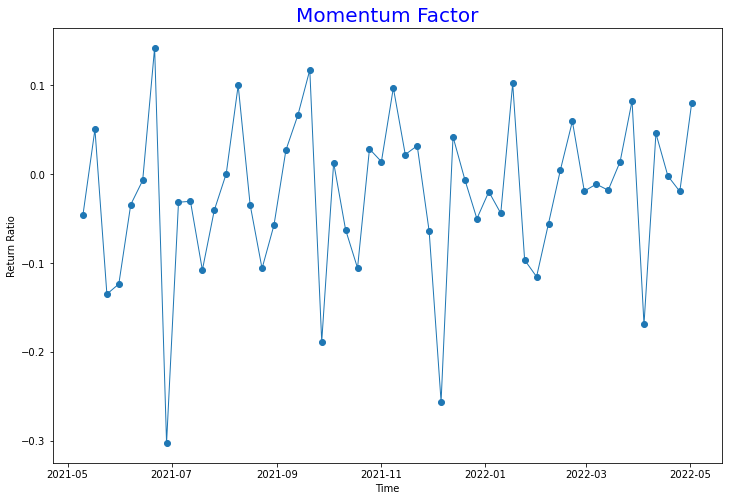

In [53]:
from matplotlib.pyplot import figure

plt.figure(figsize=(12,8))
 
plt.plot(momFactor.Date, momFactor.MOM, marker='o', linewidth=1)

plt.title("Momentum Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Return Ratio")
plt.show()

### Test

Text(0, 0.5, 'Cumulative Return')

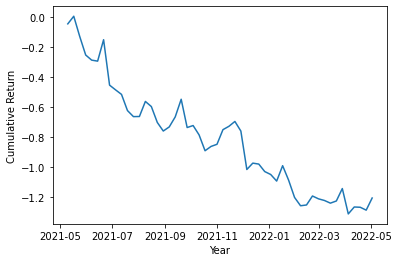

In [41]:
import matplotlib.pyplot as plt

plt.plot(momFactor.Date, np.cumsum(momFactor.MOM))
plt.xlabel('Year')
plt.ylabel('Cumulative Return')

## 6. NET Factor (Zachary)

### Get Address Growth

In [54]:
Address2 = largeCapSample.loc[:,['Date', 'ActiveAddress', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'ActiveAddress')\
                    .reset_index() \
                    .rename_axis(None, 
                                 axis = 1)
                        


In [55]:
with0 = pd.DataFrame(Address2.values == 0, columns=Address2.columns, index=Address2.index).any()
Address2[with0[with0 == 1].index.to_list()]

,BOND,RSR,WTC
0,205.0,3461.0,61.0
1,214.0,3854.0,38.0
2,166.0,2811.0,53.0
3,239.0,2320.0,41.0
4,211.0,2505.0,30.0
5,139.0,2088.0,35.0
6,132.0,2442.0,31.0
7,95.0,1275.0,12.0
8,102.0,1721.0,23.0
9,97.0,1794.0,18.0


In [56]:
Address2 = largeCapSample.loc[:,['Date', 'ActiveAddress', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'ActiveAddress')\
                    .reset_index() \
                    .rename_axis(None, 
                                 axis = 1)

Address2.replace(to_replace = 0, value = 1, inplace = True)

copy1 = Address.copy()
copy2 = copy1.shift()

Growth = copy1.copy()
cols = largeCapSample.Asset.unique().tolist()

for i in cols:
    Growth[i] = np.log(copy1[i]) - np.log(copy2[i])
    


Growth['20Percentile'] = Growth[cols].quantile(q=0.2, 
                                               numeric_only = True,
                                               axis = 1)
Growth['80Percentile'] = Growth[cols].quantile(q=0.8, 
                                               numeric_only = True, 
                                               axis = 1)

NameError: name 'Address' is not defined

In [57]:
# Get Address Growth
Address = largeCapSample.query("ActiveAddress > 0").loc[:,['Date', 'ActiveAddress', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'ActiveAddress')\
                    .reset_index() \
                    .rename_axis(None, 
                                 axis = 1)

copy1 = Address.copy()
copy2 = copy1.shift()

Growth = copy1.copy()
cols = largeCapSample.Asset.unique().tolist()

for i in cols:
    Growth[i] = np.log(copy1[i]) - np.log(copy2[i])
    


Growth['20Percentile'] = Growth[cols].quantile(q=0.2, 
                                               numeric_only = True,
                                               axis = 1)
Growth['80Percentile'] = Growth[cols].quantile(q=0.8, 
                                               numeric_only = True, 
                                               axis = 1)



In [58]:
Growth.head()

,Date,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,BAL,BAND,BAT,...,VERI,WBTC,WTC,WaBi,YFI,ZRX,sUSD,wNXM,20Percentile,80Percentile
0,2021-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-05-17,0.191315,NaN,0.032884,-0.162519,0.159630,0.284500,0.172856,0.369060,-0.001461,...,0.066894,0.251191,-0.473288,-0.005571,-0.241607,-0.003467,0.490066,0.152215,-0.162183,0.256165
2,2021-05-24,-0.094611,NaN,-0.214914,0.269129,-0.029775,0.057690,-0.095413,0.014025,0.145986,...,-0.085942,-0.233933,0.332706,-0.252912,-0.124359,0.074700,-0.113919,-0.187651,-0.254160,0.036604
3,2021-05-31,-0.342497,NaN,2.116560,-0.291434,-0.449069,-0.125892,0.047768,-0.132338,-0.111698,...,-0.313658,-0.267462,-0.256720,-0.074662,-0.397594,-0.158367,-0.034187,-0.172351,-0.349225,0.011871
4,2021-06-07,0.132049,NaN,-2.258722,0.007491,0.129170,-0.021787,-0.013001,-0.467780,-0.062354,...,0.586812,0.332523,-0.312375,-0.264693,-0.009582,-0.202537,0.117149,0.086614,-0.179467,0.155752


### Construct Network factor

In [59]:
Return = largeCapSample.loc[:, ['Date',
                                'Return',
                                'Asset']].pivot(index='Date',
                                                columns='Asset',
                                                values='Return').reset_index().rename_axis(None,
                                                                                            axis=1)

NET = pd.DataFrame({'Date': []})
NET['Date'] = Return.Date
NET['long'] = Return[Growth[cols].apply(lambda x: x >= Growth['80Percentile'])].mean(axis=1,
                                                                                        numeric_only=True)
NET['short'] = Return[Growth[cols].apply(lambda x: x <= Growth['20Percentile'])].mean(axis=1,
                                                                                        numeric_only=True)
NET.fillna(value=0, 
            inplace=True)
NET['NET'] = NET['long'] - NET['short']
NET.drop(columns=['short', 'long'])
NET = NET[['Date','NET']]
NET.head()

,Date,NET
0,2021-05-10,0.000000
1,2021-05-17,0.086529
2,2021-05-24,0.076506
3,2021-05-31,0.151894
4,2021-06-07,0.046094


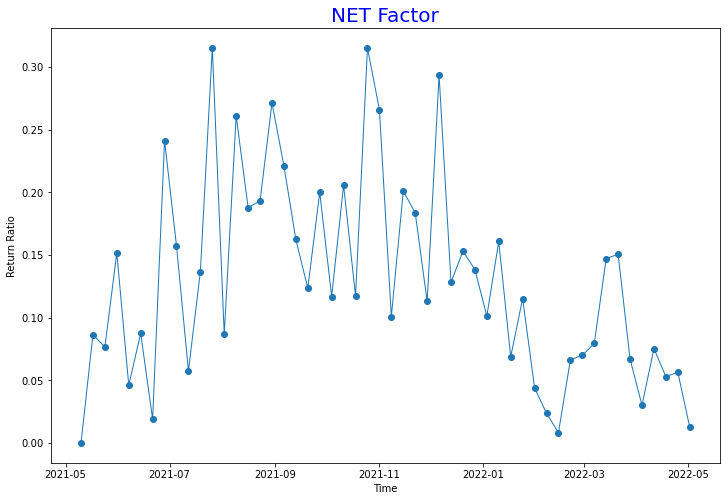

In [60]:
from matplotlib.pyplot import figure

plt.figure(figsize=(12,8))
 
plt.plot(NET.Date, NET.NET, marker='o', linewidth=1)

plt.title("NET Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Return Ratio")
plt.show()

### Test

Text(0, 0.5, 'Cumulative Return')

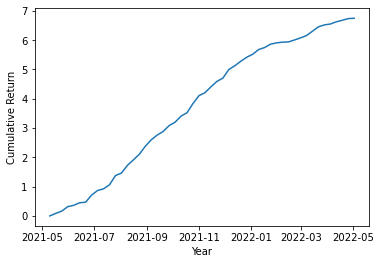

In [61]:
import matplotlib.pyplot as plt

plt.plot(NET.Date, np.cumsum(NET.NET))
plt.xlabel('Year')
plt.ylabel('Cumulative Return')

## 6. v2 NET

In [ ]:
netsample = largeCapSample[~largeCapSample['GrowthRate']. isna()]
netsample.isna().sum()

In [ ]:
largeNet = netsample.groupby(['Date']).apply(lambda x: x.nlargest(round(0.2*len(x)), 
                                                                  ['GrowthRate'])).reset_index(drop=True)

smallNet = netsample.groupby(['Date']).apply(lambda x: x.nsmallest(round(0.2*len(x)),
                                                                  ['GrowthRate'])).reset_index(drop=True)


In [ ]:
largegrow = largeNet.groupby('Date')['Return'].mean().reset_index(name='HighGrowthReturn')
smallgrow = smallNet.groupby('Date')['Return'].mean().reset_index(name='LowGrowthReturn')
largegrow['NET'] = largegrow['HighGrowthReturn'] - smallgrow['LowGrowthReturn'] 
NET_f = largegrow[['Date','NET']]

In [ ]:
NET_f['difference']=NET_f['NET']-NET['NET']
NET_f

In [ ]:
from matplotlib.pyplot import figure

plt.figure(figsize=(12,8))
 
plt.plot(NET_f.Date, NET_f.NET, marker='o', linewidth=1)

plt.title("NET Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Return Ratio")
plt.show()

In [ ]:
from matplotlib.pyplot import figure

figure(figsize = (12,8))
plt.plot(NET_f.Date, np.cumsum(NET_f.NET), marker='o', linewidth=1)
plt.title("NET Factor Cumulative Return", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Cummulative Return")
plt.show()

## 7.Regression Output
### 7.1 Output a list of alphas for all the crypto currencies using factors
Note: Only pick the top 100 cypto currencies from the latest week and check their alphas.

In [90]:
factorList = [MKT_f, SMB_f, valueFactor, momFactor, NET]
def ModelBuild(fullSample,
               factorList):
    from sklearn.linear_model import LinearRegression

    largeCapSample = fullSample.query("MarketCap > 1000000").groupby(['Date']).apply(lambda x: x.nlargest(100,['MarketCap'])).reset_index(drop=True)

    performance = {}

    ## find the top 100 cypto currencies at the last week

    latest = largeCapSample.Date.max()
    latestLarge = largeCapSample.query("Date == @latest")

    # factors = factors.merge(MOM_f, on = 'Date', how ='outer')
    from functools import reduce
    factors = reduce(lambda left, right:
                    pd.merge(left, 
                            right,
                            on='Date',
                            how='outer'),
                    factorList)

    features = factors.columns.tolist()
    features.remove('Date')
    target = "ExcessReturn"
    
    ###output the csv file for our regression data
    assetList = latestLarge['Asset'].tolist()
    regressionFrame = fullSample.loc[fullSample['Asset'].isin(assetList)]
    regressionData = regressionFrame.merge(factors, on = 'Date', how = 'outer')
    
    filename = "regressionData"+latest.strftime("%Y%m%d")+".csv"
    regressionData.to_csv(filename)


    for index in assetList:
        syntax = f"Asset == '{index}'"
        segment = fullSample.query(syntax)        
        reg = segment[['Date','ExcessReturn']].merge(factors, on = 'Date', how = 'outer')
        y = reg [target].copy()
        x = reg [features].copy()    
        model = LinearRegression()
        model.fit(x, y)
        y_pred = model.predict(x)    
        alpha = model.intercept_    
        performance[index] = alpha

        
        
        
        
    alp_sig = pd.DataFrame(list(performance.items()), 
                       columns = ['Asset','Alpha'])
    alp_sig = alp_sig.sort_values(by=['Alpha'], 
                                ascending = False).reset_index(drop=True)
    return alp_sig

In [92]:
Alphas = ModelBuild(fullSample, factorList)
latestdate = fullSample_raw.Date.max()
Alphas['Date'] = latestdate

### 7.2 Output a list of alphas for all the crypto currencies with C5 factors


In [73]:

filename2 = "alpha_list"+latestdate.strftime("%Y%m%d")+".csv"
fullSample_raw.to_csv(filename)


In [ ]:
from functools import reduce
factors = reduce(lambda left, right:
                pd.merge(left, 
                        right,
                        on='Date',
                        how='outer'),
                factorList)

from matplotlib.pyplot import figure

plt.figure(figsize=(12,10))

palette = plt.get_cmap('Set1')
 
num=0
for column in factors.drop('Date', axis=1):
    num+=1
    plt.plot(factors['Date'], factors[column], marker='o',  linewidth=1, alpha=0.9, label=column)


plt.legend(loc=2, ncol=2)
plt.title("Factors", loc='center', fontsize=20, fontweight=0, color='green')
plt.xlabel("Time")
plt.ylabel("Returns")
plt.show()

## Test

In [ ]:
from functools import reduce
factors = reduce(lambda left, right:
                pd.merge(left, 
                        right,
                        on='Date',
                        how='outer'),
                factorList)

from matplotlib.pyplot import figure

plt.figure(figsize=(12,10))

palette = plt.get_cmap('Set1')
 
num=0
for column in factors.drop('Date', axis=1):
    num+=1
    plt.plot(factors['Date'], np.cumsum(factors[column]), marker='o',  linewidth=1, alpha=0.9, label=column)


plt.legend(loc=2, ncol=2)
plt.title("Factor Presentation", loc='center', fontsize=20, fontweight=0, color='green')
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.show()